# _(Mi, et. al., 2017)_ STP for Working Memory Capacity

Implementation of the paper:

- Mi, Yuanyuan, Mikhail Katkov, and Misha Tsodyks. "Synaptic correlates of working memory capacity." Neuron 93.2 (2017): 323-330.

In [1]:
import numpy as np
import brainpy as bp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
dt = 0.0001  # [s]
bp.profile.set(jit=True, dt=dt)

In [3]:
alpha = 1.5
J_EE = 8.  # the connection strength in each excitatory neural clusters
J_IE = 1.75  # Synaptic efficacy E → I
J_EI = 1.1  # Synaptic efficacy I → E
tau_f = 1.5  # time constant of STF  [s]
tau_d = .3  # time constant of STD  [s]
U = 0.3  # minimum STF value
tau = 0.008  # time constant of firing rate of the excitatory neurons [s]
tau_I = tau  # time constant of firing rate of the inhibitory neurons

Ib = 8.  # background input and external input
Iinh = 0.  # the background input of inhibtory neuron

cluster_num = 16  # the number of the clusters

In [4]:
# the parameters of external input

stimulus_num = 5
Iext_train = 225  # the strength of the external input
Ts_interval = 0.070  # the time interval between the consequent external input [s]
Ts_duration = 0.030  # the time duration of the external input [s]
duration = 2.500  # [s]

In [5]:
# the excitatory cluster model

@bp.integrate
def int_u(u, t, r):
    return (U - u) / tau_f + U * (1 - u) * r


@bp.integrate
def int_x(x, t, u, r):
    return (1 - x) / tau_d - u * x * r


@bp.integrate
def int_h(h, t, u, x, r, r_i, Iext):
    return (-h + J_EE * u * x * r - J_EI * r_i + Iext + Ib) / tau


def exc_update(ST, _t, inh):
    ST['h'] = int_h(ST['h'], _t, ST['u'], ST['x'], ST['r'], inh['r'], ST['input'])
    ST['u'] = int_u(ST['u'], _t, ST['r'])
    ST['x'] = int_x(ST['x'], _t, ST['u'], ST['r'])
    ST['r'] = alpha * np.log(1. + np.exp(ST['h'] / alpha))
    ST['input'] = 0.


cluster_model = bp.NeuType(name='cluster',
                           ST=bp.NeuState('h', 'r', 'input', u=U, x=1.),
                           steps=exc_update)

In [6]:
# the inhibitory pool model


@bp.integrate
def int_hi(h, t, r_e):
    return (-h + J_IE * np.sum(r_e) + Iinh) / tau_I


def inh_update(ST, _t, exc):
    ST['h'] = int_hi(ST['h'], _t, exc['r'])
    ST['r'] = alpha * np.log(1 + np.exp(ST['h'] / alpha))


inh_model = bp.NeuType(name='inh', ST=bp.NeuState('h', 'r'), steps=inh_update)

In [7]:
# the external input

I_inputs = np.zeros((int(duration / dt), cluster_num))
for i in range(stimulus_num):
    t_start = (Ts_interval + Ts_duration) * i + Ts_interval
    t_end = t_start + Ts_duration
    idx_start, idx_end = int(t_start / dt), int(t_end / dt)
    I_inputs[idx_start: idx_end, i] = Iext_train

In [8]:
# network running

inh_pool = bp.NeuGroup(inh_model, geometry=1, monitors=['r'])
clusters = bp.NeuGroup(cluster_model, geometry=cluster_num, monitors=['u', 'x', 'r', 'h'],)
inh_pool.exc = clusters.ST
clusters.inh = inh_pool.ST
net = bp.Network(clusters, inh_pool)
net.run(duration, inputs=[clusters, 'input', I_inputs])

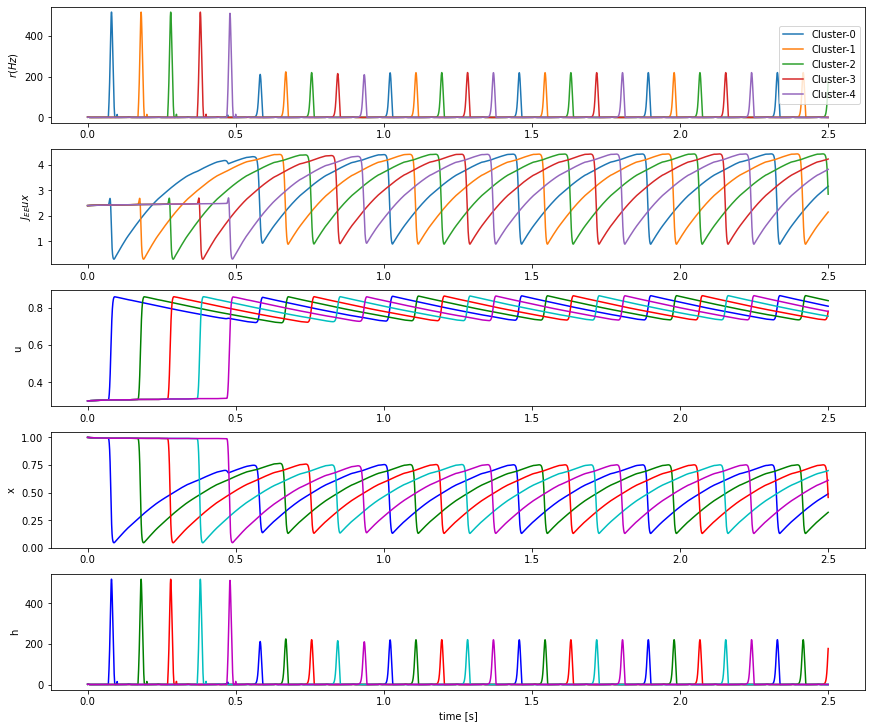

In [9]:
# visualization

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
fig.add_subplot(gs[0, 0])
for i in range(stimulus_num):
    plt.plot(net.ts, clusters.mon.r[:, i], label='Cluster-{}'.format(i))
plt.ylabel("$r (Hz)$")
plt.legend(loc='right')

fig.add_subplot(gs[1, 0])
hist_Jux = J_EE * clusters.mon.u * clusters.mon.x
for i in range(stimulus_num):
    plt.plot(net.ts, hist_Jux[:, i])
plt.ylabel("$J_{EE}ux$")

fig.add_subplot(gs[2, 0])
for i in range(stimulus_num):
    plt.plot(net.ts, clusters.mon.u[:, i], colors[i])
plt.ylabel('u')

fig.add_subplot(gs[3, 0])
for i in range(stimulus_num):
    plt.plot(net.ts, clusters.mon.x[:, i], colors[i])
plt.ylabel('x')

fig.add_subplot(gs[4, 0])
for i in range(stimulus_num):
    plt.plot(net.ts, clusters.mon.r[:, i], colors[i])
plt.ylabel('h')
plt.xlabel('time [s]')

plt.show()
